## Analysis and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

import warnings as w
w.filterwarnings('ignore')

In [2]:
data = pd.read_csv('users_behavior.csv')
data.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


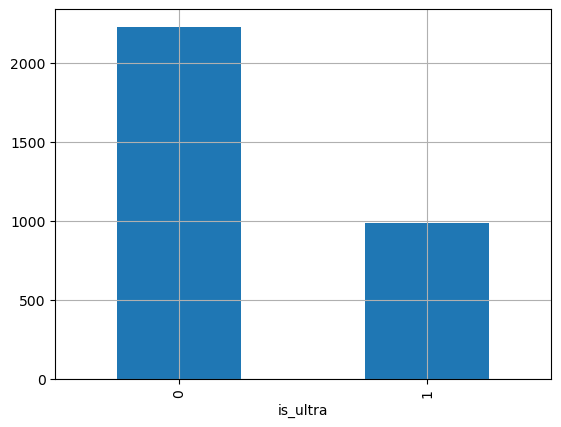

In [4]:
data['is_ultra'].value_counts().plot(kind='bar', grid=True);

In [5]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    return shuffle(features_upsampled, target_upsampled, random_state=1)

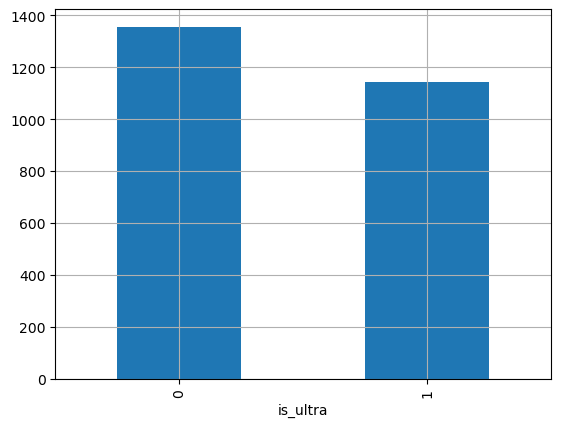

In [6]:
data_train, data_other = train_test_split(data, test_size=0.4, random_state=1)
data_valid, data_test = train_test_split(data_other, test_size=0.5, random_state=1)

X_train = data_train.drop('is_ultra', axis=1)
y_train = data_train['is_ultra']
X_valid = data_valid.drop('is_ultra', axis=1)
y_valid = data_valid['is_ultra']
X_test = data_test.drop('is_ultra', axis=1)
y_test = data_test['is_ultra']

X_train_up, y_train_up = upsample(X_train, y_train, 2)
y_train_up.value_counts().plot(kind='bar', grid=True);

In [7]:
numeric = []
[numeric.append(i) for i in data_train.columns if data_train[i].dtype == 'float' or data_train[i].dtype == 'int']
categorial = []
[categorial.append(i) for i in data_train.columns if data_train[i].dtype == 'object']

def modeling(model, params_grid, features, target):
    preprocessor = ColumnTransformer([('ohe', OneHotEncoder(), categorial),
                                      ('scaler', StandardScaler(), numeric)])
    pipeline = Pipeline([('preprocessor', preprocessor),
                         ('model', GridSearchCV(model, 
                                                params_grid,
                                                scoring='accuracy',
                                                cv=5))]).fit(features, target)
    
    print(pipeline['model'].best_score_, pipeline['model'].best_params_, sep='\n')
    return pipeline

## RandomForestClassifier

In [8]:
%%time
model = RandomForestClassifier(random_state=1)
rfc_params = {'max_depth': range(4, 8),
              'n_estimators': range(50, 91, 10),
              'min_samples_split': range(2, 5),
              'min_samples_leaf': range(2, 5)}
rfc_model = modeling(model, rfc_params, X_train_up, y_train_up)
rfc_valid = accuracy_score(y_valid, rfc_model.predict(X_valid))
print(rfc_valid)

0.7788
{'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 80}
0.7916018662519441
CPU times: total: 4min 55s
Wall time: 4min 56s


## KNeighborsClassifier

In [9]:
%%time
model = KNeighborsClassifier()
knc_params = {
    'n_neighbors': range(70),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4]
}
knc_model = modeling(model, knc_params, X_train_up, y_train_up)
knc_valid = accuracy_score(y_valid, knc_model.predict(X_valid))
print(knc_valid)

0.9164000000000001
{'n_neighbors': 63, 'p': 3, 'weights': 'distance'}
0.7916018662519441
CPU times: total: 1min 24s
Wall time: 1min 24s


## XGBClassifier

In [10]:
%%time
model = XGBClassifier(random_state=1)
xgb_params = {'max_depth': range(2, 10),
              'learning_rate': [0.05,0.1],
              'n_estimators': range(10, 101, 10)}
xgb_model = modeling(model, xgb_params, X_train_up, y_train_up)
xgb_valid = accuracy_score(y_valid, xgb_model.predict(X_valid))
print(xgb_valid)

0.836
{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}
0.7869362363919129
CPU times: total: 4min 2s
Wall time: 1min 21s


## Overall result and test

In [11]:
objects = [[rfc_model['model'].best_score_, rfc_valid],
           [knc_model['model'].best_score_, knc_valid],
           [xgb_model['model'].best_score_, xgb_valid]]
columns = ['train', 'valid']
overall = pd.DataFrame(data=objects,
                       columns=columns,
                       index=['RFC', 'KNC', 'XGB'])
overall

,train,valid
RFC,0.7788,0.791602
KNC,0.9164,0.791602
XGB,0.8360,0.786936


In [12]:
rfc_test = accuracy_score(y_test, rfc_model.predict(X_test))
rfc_test

0.7900466562986003